In [1]:
import sys
sys.path.append("..")
from src.registry import TASKS
from src.constructor.config_structure import TrainConfigParams
from src.constructor import create_trainer
from src.constructor.config_structure import TrainConfigParams
from src.registry import TASKS
from src.constructor.data import create_dataset
from train import load_config
from torch.utils.data import DataLoader
from tqdm import tqdm
from matplotlib import pyplot as plt
import cv2
import torch

In [2]:
def view_sample(df_sample, model, device):
    '''
    Code taken from Peter's Kernel 
    https://www.kaggle.com/pestipeti/pytorch-starter-fasterrcnn-train
    '''
    ds_val = ReefDataset(df_sample, get_valid_transform())
    dl_val = DataLoader(ds_val, batch_size=BATCH_SIZE, shuffle=False,
                        num_workers=4, collate_fn=collate_fn)
    
    images, targets, image_ids = next(iter(dl_val))
    
    images = list(img.to(device) for img in images)
    targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
    
    # [x_center, y_center, width, height] # All scaled
    boxes = targets[0]['boxes'].cpu().numpy()
    # De-scaled
    boxes = np.array([np.array(box).astype(np.int32) for box in A.augmentations.bbox_utils.denormalize_bboxes(boxes, HEIGHT, WIDTH)])
    #boxes['x'] = boxes['x'] + (boxes['width'] / 2)
    #boxes['y'] = boxes['y'] + (boxes['height'] / 2)

    
    #[x_min, y_min, width, height]
    boxes[:, 0] = boxes[:, 0] - (boxes[:, 2] / 2) # x_center --> x_min
    boxes[:, 1] = boxes[:, 1] - (boxes[:, 3] / 2) # y_center --> y_min
    
    sample = images[0].permute(1,2,0).cpu().numpy()
    
    model.eval()
    model.to(device)
    cpu_device = torch.device("cpu")
    
    with torch.no_grad():
        outputs = model(images)
        
    outputs = [{k: v.to(cpu_device) for k, v in outputs.items()}]
    
    fig, ax = plt.subplots(1, 1, figsize=(16, 8))
    for box in boxes:
        x, y, w, h = box
        cv2.rectangle(sample, (x, y), (x+w, y+h), (0, 220, 0), 3)
        
        

    oboxes = outputs[0]['pred_boxes'][0].detach().cpu().numpy()
    oboxes = np.array([np.array(box).astype(np.int32) for box in A.augmentations.bbox_utils.denormalize_bboxes(oboxes, HEIGHT, WIDTH)])
    
    # [x_min, y_min, width, height]
    oboxes[:, 0] = oboxes[:, 0] - (oboxes[:, 2] / 2) # x_center --> x_min
    oboxes[:, 1] = oboxes[:, 1] - (oboxes[:, 3] / 2) # y_center --> y_min
    
    prob   = outputs[0]['pred_logits'][0].softmax(1).detach().cpu().numpy()[:,0]
    #print(f"Probabilities: {prob}")
    scored_boxes = list(zip(oboxes, prob))
    sorted_boxes = list(sorted(scored_boxes, key=lambda y: -y[1]))
    print([score for _, score in sorted_boxes][:10])
    for i, (box, p) in enumerate(sorted_boxes):
        x, y, w, h = box
        
        if p > 0.5:
            cv2.rectangle(sample, (x, y), (x+w, y+h), (220, 0, 0), 3)
        
        if i > 18:
            break

            
    ax.set_axis_off()
    ax.imshow(sample)
    
    
# model = DETRModel(num_classes=NUM_CLASSES, num_queries=NUM_QUERIES)
# model.load_state_dict(torch.load("./pytorch_model.bin"))

In [3]:
# view_sample(df_sample=df_val[df_val['n_annotations'] > 3].iloc[[30]], model=model,device=torch.device('cuda'))

In [4]:
config_yaml = load_config("../examples/configs/deformable_detr_detection.yml")
config = TrainConfigParams(**config_yaml)

model = TASKS.get(config.task.name)(config)

model name resnet50_v2
Pretrained weights for resnet50_v2 will be downloaded


In [5]:
model_pth = "/mnt/voice/gazizullina/workdir/lightning_runs/barrier_reef/deformable_detr_v1/2022-02-03_12-20-36/last.ckpt"
ckpt = torch.load(model_pth)["state_dict"]
model.load_state_dict(ckpt)
model.eval();

In [6]:
data_params = config.data
dataset_name = data_params.valid_params.name
common_params = data_params.common_params
other_params = data_params.valid_params

dataset = create_dataset(dataset_name, common_params, other_params)
dataloader = DataLoader(dataset, batch_size=2, shuffle=False, collate_fn=dataset.collate_fn)

In [7]:

# for b in tqdm(dataloader, total=len(dataloader)):
#     preds_pairs, gt_pairs = model.forward_eval(b)


In [8]:
iter_dt = iter(dataloader)

In [17]:
batch = next(iter_dt)

In [18]:
preds, gts = model.forward_eval(batch)

tensor([1104,  445, 1202,  475])
tensor([1103,  402, 1193,  431])


In [19]:
class UnNormalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        """
        Args:
            tensor (Tensor): Tensor image of size (C, H, W) to be normalized.
        Returns:
            Tensor: Normalized image.
        """
        for t, m, s in zip(tensor, self.mean, self.std):
            t.mul_(s).add_(m)
            # The normalize code -> t.sub_(m).div_(s)
        return tensor

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


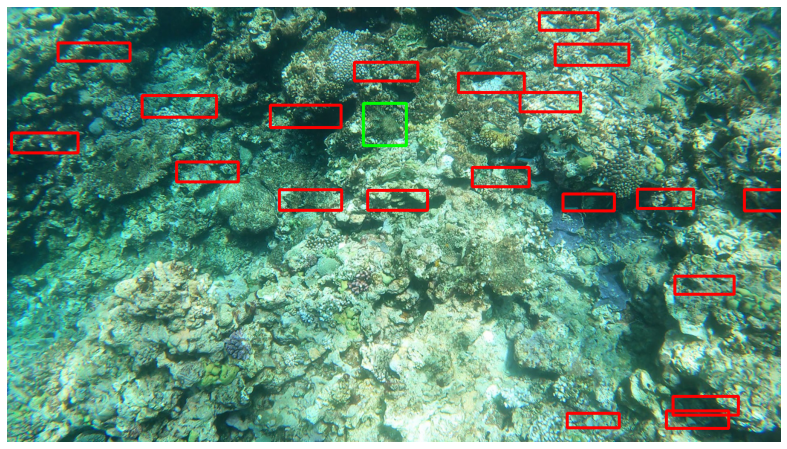

In [20]:
sample_i = batch['input'][0] #.transpose(0, 2).numpy()
unorm = UnNormalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
sample = cv2.UMat(unorm(sample_i).transpose(0, 2).transpose(0, 1).numpy()).get()
fig, ax = plt.subplots(1, 1, figsize=(16, 8))
for box in gts[0][0]:
    xmin, ymin, xmax, ymax = box.numpy()
    x = xmin
    y = ymin
    w = xmax - xmin
    h = ymax - ymin
    cv2.rectangle(sample, (int(x), int(y)), (int(x+w), int(y+h)), (0, 220, 0), 3)
    
for i, box in enumerate(preds[0][0]):
    
    xmin, ymin, xmax, ymax = box.numpy()
    
    x = xmin
    y = ymin
    w = xmax - xmin
    h = ymax - ymin
    cv2.rectangle(sample, (int(x), int(y)), (int(x+w), int(y+h)), (220, 0, 0), 3)

ax.set_axis_off()
ax.imshow(sample)